# Seq2Seq using Encoder-Decoder model

In this session, we will cover how to use encoder-decoder model for seq2seq problems. 

## What is sequence-to-sequence learning?
Sequence-to-sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to French).
```
"the cat sat on the mat" -> [Seq2Seq model] -> "le chat etait assis sur le tapis"
```

This can be used for machine translation or for free-from question answering (generating a natural language answer given a natural language question) -- in general, it is applicable any time you need to generate text.



### Encoder-Decoder
In the general case, input sequences and output sequences have different lengths (e.g. machine translation) and the entire input sequence is required in order to start predicting the target. This requires a more advanced setup, which is what people commonly refer to when mentioning "sequence to sequence models" with no further context. Here's how it works:
*   A RNN layer (or stack thereof) acts as "encoder": it processes the input 
sequence and returns its own internal state. Note that we discard the outputs of the encoder RNN, only recovering the state. This state will serve as the "context", or "conditioning", of the decoder in the next step.
*   Another RNN layer (or stack thereof) acts as "decoder": it is trained to predict the next characters of the target sequence, given previous characters of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate. Effectively, the decoder learns to generate *targets[t+1...]* given *targets[...t]*, conditioned on the input sequence.

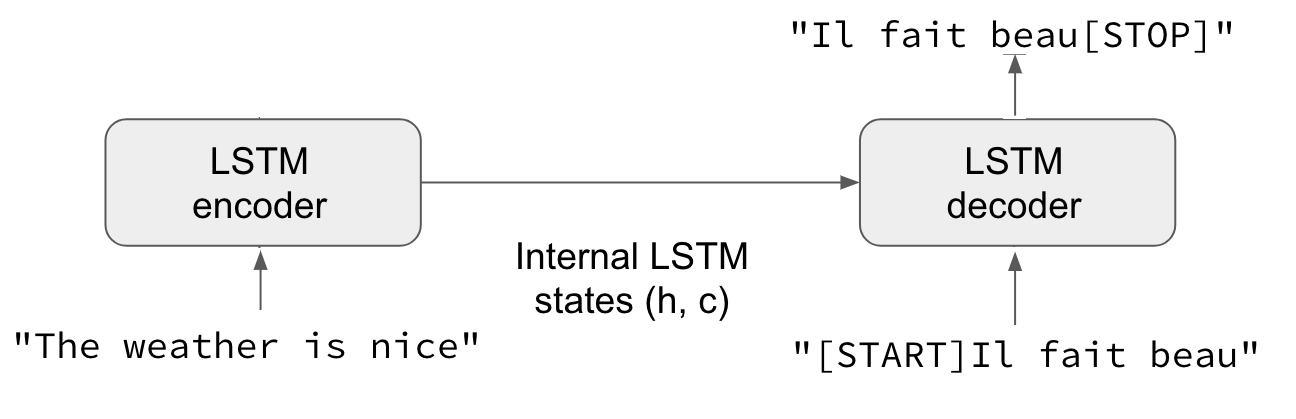




In **inference mode**, i.e. when we want to decode unknown input sequences, we go through a slightly different process:

1.   Encode the input sequence into state vectors.
1.   Start with a target sequence of size 1 (just the start-of-sequence character).
1.   Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character.
1.   Sample the next character using these predictions (we simply use argmax).
1.   Append the sampled character to the target sequence
1.   Repeat until we generate the end-of-sequence character or we hit the character limit.

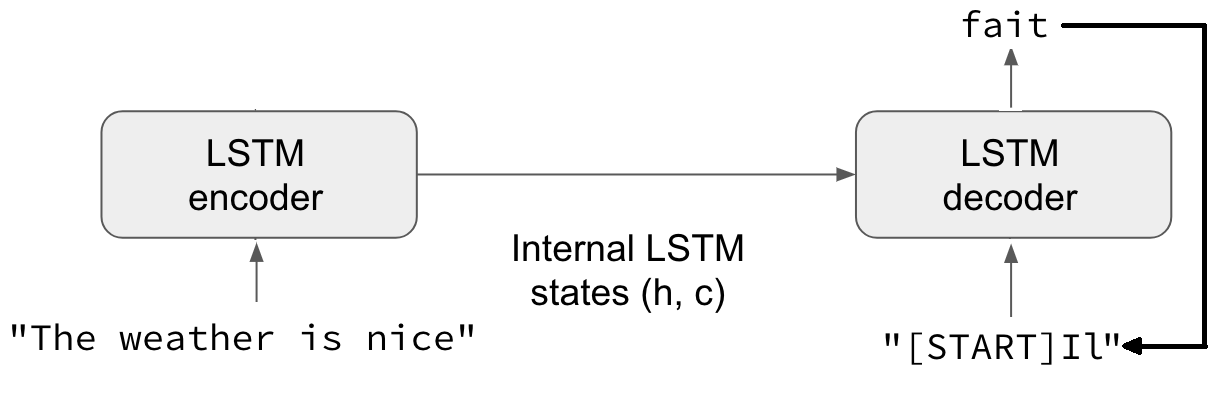

## Data Preparation

In [ ]:
# setup
import numpy as np
import tensorflow as tf
from tensorflow import keras

### Download the data

For our example implementation, we will use a dataset of pairs of English sentences and their French translation, which you can download from [manythings.org/anki](https://http://www.manythings.org/anki/). The file to download is called fra-eng.zip. We will implement a character-level sequence-to-sequence model, processing the input character-by-character and generating the output character-by-character. Another option would be a word-level model, which tends to be more common for machine translation. At the end of this post, you will find some notes about turning our model into a word-level model using Embedding layers.

In [ ]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

### Configuration

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 30  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"

### Prepare the data

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# read all file contents
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)

    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)

    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [ ]:
input_characters[1:5]

## Build the model

Here's a summary of our process:


1.   Turn the sentences into 3 Numpy arrays, *encoder_input_data*, *decoder_input_data*, *decoder_target_data*:
*   encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.
*   decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.
*   decoder_target_data is the same as decoder_input_data but offset by one timestep. *decoder_target_data[:, t, :]* will be the same as *decoder_input_data[:, t + 1, :]*.
2.   Train a basic LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data. Our model uses teacher forcing.
3.   Decode some sentences to check that the model is working (i.e. turn samples from encoder_input_data into corresponding samples from decoder_target_data).


Because the training process and inference process (decoding sentences) are quite different, we use different models for both, albeit they all leverage the same inner layers.

This is our training model. It leverages three key features of Keras RNNs:

*   The **return_state** contructor argument, configuring a RNN layer to return a 
list where the first entry is the outputs and the next entries are the internal RNN states. This is used to recover the states of the encoder.
*   The **inital_state** call argument, specifying the initial state(s) of a RNN. This is used to pass the encoder states to the decoder as initial states.
*   The **return_sequences** constructor argument, configuring a RNN to return its full sequence of outputs (instead of just the last output, which the defaults behavior). This is used in the decoder.


In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_outputs = Dense(num_decoder_tokens, activation='softmax')(decoder_outputs)
#decoder_outputs = decoder_dense(decoder_outputs)



In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 71)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 92)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        335872      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

### Train the model

We train our model in two lines, while monitoring the loss on a held-out set of 20% of the samples.



In [ ]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=10,
          validation_split=0.2)

Epoch 1/10
125/125 [==============================] - 13s 49ms/step - loss: 1.1395 - val_loss: 1.0168
Epoch 2/10
125/125 [==============================] - 5s 37ms/step - loss: 0.8269 - val_loss: 0.8387
Epoch 3/10
125/125 [==============================] - 5s 37ms/step - loss: 0.6655 - val_loss: 1.0000
Epoch 4/10
125/125 [==============================] - 4s 35ms/step - loss: 0.5789 - val_loss: 0.6388
Epoch 5/10
125/125 [==============================] - 4s 34ms/step - loss: 0.5303 - val_loss: 0.5916
Epoch 6/10
125/125 [==============================] - 4s 34ms/step - loss: 0.4954 - val_loss: 0.5656
Epoch 7/10
125/125 [==============================] - 4s 34ms/step - loss: 0.4659 - val_loss: 0.5380
Epoch 8/10
125/125 [==============================] - 4s 34ms/step - loss: 0.4412 - val_loss: 0.5211
Epoch 9/10
125/125 [==============================] - 4s 34ms/step - loss: 0.4195 - val_loss: 0.5094
Epoch 10/10
125/125 [==============================] - 4s 35ms/step - loss: 0.4009 - val_l

## Run inference (sampling)

To decode a test sentence, we will repeatedly:
1.   Encode the input sentence and retrieve the initial decoder state
2.   Run one step of the decoder with this initial state and a "start of sequence" token as target. The output will be the next target character.
3.   Append the target character predicted and repeat.
Here's our inference setup:



In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


In [ ]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


We use it to implement the inference loop described above:


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


You can now generate decoded sentences as such:

In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

## Aknowledgment
This lab is based on the "Training a video classifier with transfer learning and a recurrent model on the UCF101 dataset." by Sayak Paul.
 